In [239]:
import pandas as pd
import re
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from datetime import datetime as dt
import isodate
import numpy as np
from collections import defaultdict
from ast import literal_eval
from statistics import mean
import stanza # Stanford NLP
import enchant
english_dictionary = enchant.Dict("en_US")

In [2]:
submissions = pd.read_csv("submissions.csv", converters={"variableNames": lambda x: x.strip("[]").replace("'","").split(", ")}) # variableNames is a list but is read as a string, so we must convert
submissions.head() # At the beginning, most variable lists are empty since students are not initializing their own

,email,assessment,timestamp,mode,variableNames
0,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:29:54 CDT 2019,Public,[]
1,buyg4@illinois.edu,750470,Mon Sep 02 20:02:14 CDT 2019,Public,[]
2,buyg4@illinois.edu,750470,Mon Sep 02 20:05:17 CDT 2019,Public,[]
3,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:01:50 CDT 2019,Public,[]
4,annu9@illinois.edu,750470,Tue Sep 03 11:21:33 CDT 2019,Public,[]


In [3]:
def string_to_dict(string):
    abbreviated_string = string.replace("{" ,"").replace("}" , "")
    kv_pairs = abbreviated_string.split(",")
    if len(kv_pairs) == 0:
        return dict()
    dictionary = dict()
    for kv_pair in kv_pairs:
        if kv_pair == "":
            continue
        kv_pair = kv_pair.split("=")
        m = kv_pair[0].strip('\'').replace("\"", "")
        dictionary[m] = kv_pair[1].strip('"\'')
    return dictionary

In [4]:
assessments = pd.read_csv("assessments.csv", converters={"variableNameCounts": lambda x: string_to_dict(x)})
assessments.head()

,assessment,variableNameCounts,numSubmissions
0,1126925,"{'toReturn': '2', ' num': '1', ' numBelow': '1...",134
1,997173,"{'minC': '2', ' toReturn': '4', ' toComp': '1'...",610
2,821130,"{'a': '1', ' arraySum': '5', ' array': '2', ' ...",14
3,1098075,"{'temporary': '3', ' tries': '1', ' smaller': ...",532
4,1076630,"{'usa': '1', ' toReturn': '6', ' val2': '1', '...",564


In [5]:
assessments['variableNameProportions'] = assessments.apply(lambda row: {k: int(v) / int(row["numSubmissions"]) for k, v in row["variableNameCounts"].items()}, axis=1)
assessments = assessments[['assessment', 'variableNameCounts', 'variableNameProportions', 'numSubmissions']]
assessments.head()

,assessment,variableNameCounts,variableNameProportions,numSubmissions
0,1126925,"{'toReturn': '2', ' num': '1', ' numBelow': '1...","{'toReturn': 0.014925373134328358, ' num': 0.0...",134
1,997173,"{'minC': '2', ' toReturn': '4', ' toComp': '1'...","{'minC': 0.003278688524590164, ' toReturn': 0....",610
2,821130,"{'a': '1', ' arraySum': '5', ' array': '2', ' ...","{'a': 0.07142857142857142, ' arraySum': 0.3571...",14
3,1098075,"{'temporary': '3', ' tries': '1', ' smaller': ...","{'temporary': 0.005639097744360902, ' tries': ...",532
4,1076630,"{'usa': '1', ' toReturn': '6', ' val2': '1', '...","{'usa': 0.0017730496453900709, ' toReturn': 0....",564


In [34]:
assessments['commonVars'] = assessments.apply(lambda row: {k.strip():v for (k,v) in row['variableNameProportions'].items() if v > 0.9}.keys(), axis=1)
assessments[assessments["commonVars"] != set()]

,assessment,variableNameCounts,variableNameProportions,numSubmissions,commonVars
18,1098019,"{'amount': '1', ' get': '1', ' save': '1', ' x...","{'amount': 0.0018656716417910447, ' get': 0.00...",536,(value)
21,1069782,"{'namee': '1', ' toReturn': '8', ' prev': '1',...","{'namee': 0.002036659877800407, ' toReturn': 0...",491,"(name, age)"
39,997236,"{'otherArr': '2', ' xx': '1', ' theother': '1'...","{'otherArr': 0.003418803418803419, ' xx': 0.00...",585,"(toReturn, originalIndex, array, newArray)"
40,970444,"{'hi': '1', ' oIndex': '3', ' mod': '1', ' toR...","{'hi': 0.0016891891891891893, ' oIndex': 0.005...",592,"(toReturn, originalIndex, array, newArray)"
41,970440,"{'num': '1', ' indx': '1', ' retrieved': '1', ...","{'num': 0.0017482517482517483, ' indx': 0.0017...",572,(array)
49,916172,"{'xx': '1', ' aA': '1', ' asPet': '1', ' namee...","{'xx': 0.001639344262295082, ' aA': 0.00163934...",610,"(name, age)"
56,878968,"{'bankN': '1', ' toReturn': '14', ' aHolder': ...","{'bankN': 0.0015503875968992248, ' toReturn': ...",645,(bankName)
57,878966,"{'num': '1', ' doggysname': '1', ' Count': '2'...","{'num': 0.0015503875968992248, ' doggysname': ...",645,(count)
58,830347,"{'count1': '1', ' a': '1', ' countNew': '1', '...","{'count1': 0.0016366612111292963, ' a': 0.0016...",611,"(count, name)"
62,824079,"{'val': '1', ' a': '3', ' s': '1', ' classic':...","{'val': 0.0015174506828528073, ' a': 0.0045523...",659,(value)


In [37]:
submissions['updatedVariableNames'] = submissions.apply(lambda row: [v for v in row["variableNames"] if v not in set(assessments[assessments["assessment"] == row["assessment"]]["commonVars"].iloc[0])], axis=1)

In [38]:
submissions

,email,assessment,timestamp,mode,variableNames,updatedVariableNames
0,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:29:54 CDT 2019,Public,[],[]
1,buyg4@illinois.edu,750470,Mon Sep 02 20:02:14 CDT 2019,Public,[],[]
2,buyg4@illinois.edu,750470,Mon Sep 02 20:05:17 CDT 2019,Public,[],[]
3,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:01:50 CDT 2019,Public,[],[]
4,annu9@illinois.edu,750470,Tue Sep 03 11:21:33 CDT 2019,Public,[],[]
...,...,...,...,...,...,...
566688,fthrca7@illinois.edu,1126925,Tue Dec 10 14:10:57 CST 2019,Exam,[],[]
566689,fthrca7@illinois.edu,1126925,Tue Dec 10 14:12:51 CST 2019,Exam,[],[]
566690,pgmlia4@illinois.edu,1126925,Tue Dec 10 15:21:34 CST 2019,Exam,[count],[count]
566691,fthrca7@illinois.edu,1126925,Tue Dec 10 14:03:38 CST 2019,Exam,[count],[count]


In [40]:
submissions.to_csv("updated_submissions.csv")

In [288]:
len(assessments[assessments["commonVars"] != set()])/len(assessments)

0.17894736842105263

In [39]:
submissions[submissions["assessment"] == 802747	]

,email,assessment,timestamp,mode,variableNames,updatedVariableNames
15538,wykhzsv8@illinois.edu,802747,Mon Sep 16 21:08:57 CDT 2019,Public,"[CHARACTERS, output, index]","[output, index]"
15539,epfdsza3@illinois.edu,802747,Tue Sep 17 13:19:26 CDT 2019,Public,"[CHARACTERS, modShift]",[modShift]
15540,epfdsza3@illinois.edu,802747,Tue Sep 17 13:42:43 CDT 2019,Public,"[CHARACTERS, output, modShift]","[output, modShift]"
15541,kzlyf5@illinois.edu,802747,Tue Sep 17 20:31:17 CDT 2019,Public,"[CHARACTERS, Input]",[Input]
15542,ojgox9@illinois.edu,802747,Tue Sep 17 19:33:57 CDT 2019,Public,"[CHARACTERS, inputArray, inputCharArray, retur...","[inputArray, inputCharArray, returnString]"
...,...,...,...,...,...,...
24706,ienf2@illinois.edu,802747,Tue Sep 17 16:29:19 CDT 2019,Public,"[CHARACTERS, shiftValue]",[shiftValue]
24707,xclwtoe2@illinois.edu,802747,Tue Sep 17 19:34:46 CDT 2019,Public,"[CHARACTERS, output, position, keyVal, replace]","[output, position, keyVal, replace]"
24708,xclwtoe2@illinois.edu,802747,Tue Sep 17 19:37:58 CDT 2019,Public,"[CHARACTERS, output, position, keyVal, replace]","[output, position, keyVal, replace]"
24709,xclwtoe2@illinois.edu,802747,Tue Sep 17 19:41:03 CDT 2019,Public,"[CHARACTERS, output, position, keyVal, replace]","[output, position, keyVal, replace]"


In [41]:
def split_camel_case(var):
    return re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', var)).split()

In [101]:
def is_descriptive(var):
    words = split_camel_case(var)
    for word in words:
        if not english_dictionary.check(word):
            return False
    return True

In [79]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

def get_lemma(word):
    word = nlp(word)
    return word.sentences[0].words[0].lemma

assert get_lemma("temperatures") == "temperature"

2020-10-17 17:09:05 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-10-17 17:09:05 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |

2020-10-17 17:09:05 INFO: Use device: cpu
2020-10-17 17:09:05 INFO: Loading: tokenize
2020-10-17 17:09:05 INFO: Loading: pos
2020-10-17 17:09:06 INFO: Loading: lemma
2020-10-17 17:09:06 INFO: Done loading processors!


In [90]:
def calculate_lemma_counts(variableCounts):
    lemmaCounts = defaultdict(lambda: 0)
    for var, count in variableCounts.items():
        words = split_camel_case(var)
        for word in words:
            lemmaCounts[get_lemma(word)] += int(count)
    return lemmaCounts

In [151]:
def is_odd(var, lemmaCounts):
    words = split_camel_case(var)
    for word in words:
        lemma = get_lemma(word)
        if lemma in lemmaCounts and lemmaCounts[lemma] > 1:
            return False
    return True

is_odd("hbbubiubiubiubiubiubiubiu", assessments[assessments["assessment"] == 890037]["lemmaCounts"].iloc[0])

True

In [91]:
assessments['lemmaCounts'] = assessments.apply(lambda row: calculate_lemma_counts(row["variableNameCounts"]), axis=1)
assessments = assessments[['assessment', 'variableNameCounts', 'lemmaCounts', 'variableNameProportions', 'numSubmissions', 'commonVars']]
assessments.head()

,assessment,variableNameCounts,lemmaCounts,variableNameProportions,numSubmissions,commonVars
0,1126925,"{'toReturn': '2', ' num': '1', ' numBelow': '1...","{'to': 3, 'return': 2, 'num': 2, 'below': 1, '...","{'toReturn': 0.014925373134328358, ' num': 0.0...",134,()
1,997173,"{'minC': '2', ' toReturn': '4', ' toComp': '1'...","{'min': 114, 'C': 6, 'to': 14, 'return': 4, 'C...","{'minC': 0.003278688524590164, ' toReturn': 0....",610,()
2,821130,"{'a': '1', ' arraySum': '5', ' array': '2', ' ...","{'a': 1, 'array': 7, 'sum': 6, 'number': 1, 'i...","{'a': 0.07142857142857142, ' arraySum': 0.3571...",14,()
3,1098075,"{'temporary': '3', ' tries': '1', ' smaller': ...","{'temporary': 3, 'try': 1, 'smaller': 1, 'to':...","{'temporary': 0.005639097744360902, ' tries': ...",532,()
4,1076630,"{'usa': '1', ' toReturn': '6', ' val2': '1', '...","{'usa': 1, 'to': 7, 'return': 6, 'val2': 1, 'n...","{'usa': 0.0017730496453900709, ' toReturn': 0....",564,()


In [96]:
submissions['numTotalVar'] = submissions.apply(lambda row: len([v for v in row["updatedVariableNames"] if v != ""]), axis=1)

submissions.head()

,email,assessment,timestamp,mode,variableNames,updatedVariableNames,numTotalVar
0,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:29:54 CDT 2019,Public,[],[],0
1,buyg4@illinois.edu,750470,Mon Sep 02 20:02:14 CDT 2019,Public,[],[],0
2,buyg4@illinois.edu,750470,Mon Sep 02 20:05:17 CDT 2019,Public,[],[],0
3,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:01:50 CDT 2019,Public,[],[],0
4,annu9@illinois.edu,750470,Tue Sep 03 11:21:33 CDT 2019,Public,[],[],0


In [102]:
submissions['numDescriptiveVar'] = submissions.apply(lambda row: len([v for v in row["updatedVariableNames"] if v != "" and is_descriptive(v)]), axis=1)
submissions

,email,assessment,timestamp,mode,variableNames,updatedVariableNames,numTotalVar,numDescriptiveVar
0,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:29:54 CDT 2019,Public,[],[],0,0
1,buyg4@illinois.edu,750470,Mon Sep 02 20:02:14 CDT 2019,Public,[],[],0,0
2,buyg4@illinois.edu,750470,Mon Sep 02 20:05:17 CDT 2019,Public,[],[],0,0
3,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:01:50 CDT 2019,Public,[],[],0,0
4,annu9@illinois.edu,750470,Tue Sep 03 11:21:33 CDT 2019,Public,[],[],0,0
...,...,...,...,...,...,...,...,...
566688,fthrca7@illinois.edu,1126925,Tue Dec 10 14:10:57 CST 2019,Exam,[],[],0,0
566689,fthrca7@illinois.edu,1126925,Tue Dec 10 14:12:51 CST 2019,Exam,[],[],0,0
566690,pgmlia4@illinois.edu,1126925,Tue Dec 10 15:21:34 CST 2019,Exam,[count],[count],1,1
566691,fthrca7@illinois.edu,1126925,Tue Dec 10 14:03:38 CST 2019,Exam,[count],[count],1,1


In [152]:
submissions['numOddVar'] = submissions.apply(lambda row: len([v for v in row["updatedVariableNames"] if v != "" and is_odd(v, assessments[assessments["assessment"] == int(row["assessment"])]["lemmaCounts"].iloc[0])]), axis=1)
submissions

,email,assessment,timestamp,mode,variableNames,updatedVariableNames,numTotalVar,numDescriptiveVar,numOddVar,avgVarLength
0,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:29:54 CDT 2019,Public,[],[],0,0,0,NaN
1,buyg4@illinois.edu,750470,Mon Sep 02 20:02:14 CDT 2019,Public,[],[],0,0,0,NaN
2,buyg4@illinois.edu,750470,Mon Sep 02 20:05:17 CDT 2019,Public,[],[],0,0,0,NaN
3,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:01:50 CDT 2019,Public,[],[],0,0,0,NaN
4,annu9@illinois.edu,750470,Tue Sep 03 11:21:33 CDT 2019,Public,[],[],0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
566688,fthrca7@illinois.edu,1126925,Tue Dec 10 14:10:57 CST 2019,Exam,[],[],0,0,0,NaN
566689,fthrca7@illinois.edu,1126925,Tue Dec 10 14:12:51 CST 2019,Exam,[],[],0,0,0,NaN
566690,pgmlia4@illinois.edu,1126925,Tue Dec 10 15:21:34 CST 2019,Exam,[count],[count],1,1,0,5.0
566691,fthrca7@illinois.edu,1126925,Tue Dec 10 14:03:38 CST 2019,Exam,[count],[count],1,1,0,5.0


In [141]:
submissions.head()

,email,assessment,timestamp,mode,variableNames,updatedVariableNames,numTotalVar,numDescriptiveVar,numOddVar,avgVarLength
0,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:29:54 CDT 2019,Public,[],[],0,0,0,NaN
1,buyg4@illinois.edu,750470,Mon Sep 02 20:02:14 CDT 2019,Public,[],[],0,0,0,NaN
2,buyg4@illinois.edu,750470,Mon Sep 02 20:05:17 CDT 2019,Public,[],[],0,0,0,NaN
3,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:01:50 CDT 2019,Public,[],[],0,0,0,NaN
4,annu9@illinois.edu,750470,Tue Sep 03 11:21:33 CDT 2019,Public,[],[],0,0,0,NaN


In [121]:
def extended_mean(l):
    if len(l) == 0:
        return None
    else:
        return mean(l)

submissions['avgVarLength'] = submissions.apply(lambda row: extended_mean([len(v) for v in row["updatedVariableNames"] if v != ""]), axis=1)
submissions

,email,assessment,timestamp,mode,variableNames,updatedVariableNames,numTotalVar,numDescriptiveVar,numOddVar,avgVarLength
0,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:29:54 CDT 2019,Public,[],[],0,0,0,NaN
1,buyg4@illinois.edu,750470,Mon Sep 02 20:02:14 CDT 2019,Public,[],[],0,0,0,NaN
2,buyg4@illinois.edu,750470,Mon Sep 02 20:05:17 CDT 2019,Public,[],[],0,0,0,NaN
3,wykhzsv8@illinois.edu,750470,Mon Sep 02 18:01:50 CDT 2019,Public,[],[],0,0,0,NaN
4,annu9@illinois.edu,750470,Tue Sep 03 11:21:33 CDT 2019,Public,[],[],0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
566688,fthrca7@illinois.edu,1126925,Tue Dec 10 14:10:57 CST 2019,Exam,[],[],0,0,0,NaN
566689,fthrca7@illinois.edu,1126925,Tue Dec 10 14:12:51 CST 2019,Exam,[],[],0,0,0,NaN
566690,pgmlia4@illinois.edu,1126925,Tue Dec 10 15:21:34 CST 2019,Exam,[count],[count],1,1,1,5.0
566691,fthrca7@illinois.edu,1126925,Tue Dec 10 14:03:38 CST 2019,Exam,[count],[count],1,1,1,5.0


In [159]:
people = pd.read_csv("people.csv")

In [160]:
cs_re = re.compile(r'Computer Science|CS|Comp Sci')
eng_re = re.compile(r'Grainger|Engineering')

people["updated_major"] = "N/A"
for i in range(0, len(people)):
    major = people.iloc[i].major
    college = people.loc[i]["college"]
    
    try:
        if cs_re.search(major):
            try:
                if eng_re.search(college):
                    people.at[i, "updated_major"] = "CS-Eng"
                else:
                    people.at[i, "updated_major"] = "CS+X"
            except:
                people.at[i, "updated_major"] = "Other"
        else:
            people.at[i, "updated_major"] = "Other"
    except:
        people.at[i, "updated_major"] = "Other"
        
    
people.head()

,email,gender,major,college,priorCSExperience,updated_major
0,aapccr2@illinois.edu,M,Pre-Engineering,Division of General Studies,HS Only,Other
1,anar9@illinois.edu,M,Engineering Physics,Grainger Engineering,Uni Only,Other
2,bgpo5@illinois.edu,F,Math & Computer Science,Liberal Arts & Sciences,None,CS+X
3,bkkhyb8@illinois.edu,M,Statistics & Computer Science,Liberal Arts & Sciences,HS Only,CS+X
4,cqrejfm4@illinois.edu,F,Econometrics & Quant Econ,Liberal Arts & Sciences,Uni Only,Other


In [161]:
people['numTotalVar'] = people.apply(lambda row: submissions[submissions["email"] == row["email"]]["numTotalVar"].sum(), axis=1)
people

,email,gender,major,college,priorCSExperience,updated_major,numTotalVar
0,aapccr2@illinois.edu,M,Pre-Engineering,Division of General Studies,HS Only,Other,1334
1,anar9@illinois.edu,M,Engineering Physics,Grainger Engineering,Uni Only,Other,272
2,bgpo5@illinois.edu,F,Math & Computer Science,Liberal Arts & Sciences,None,CS+X,2074
3,bkkhyb8@illinois.edu,M,Statistics & Computer Science,Liberal Arts & Sciences,HS Only,CS+X,416
4,cqrejfm4@illinois.edu,F,Econometrics & Quant Econ,Liberal Arts & Sciences,Uni Only,Other,68
...,...,...,...,...,...,...,...
894,xqmc2@illinois.edu,M,Computer Science,Grainger Engineering,HS Only,CS-Eng,1081
895,zhqwm9@illinois.edu,M,Mathematics,Liberal Arts & Sciences,HS Only,Other,296
896,zoymqu6@illinois.edu,M,Computer Science&Crop Sciences,"Agr, Consumer, & Env Sciences",None,CS+X,69
897,zsaevtg2@illinois.edu,M,Mathematics,Liberal Arts & Sciences,None,Other,1354


In [172]:
people['numDescriptiveVar'] = people.apply(lambda row: submissions[submissions["email"] == row["email"]]["numDescriptiveVar"].sum(), axis=1)
people

,email,gender,major,college,priorCSExperience,updated_major,numTotalVar,numOddVar,numDescriptiveVar
0,aapccr2@illinois.edu,M,Pre-Engineering,Division of General Studies,HS Only,Other,1334,118,1323
1,anar9@illinois.edu,M,Engineering Physics,Grainger Engineering,Uni Only,Other,272,3,249
2,bgpo5@illinois.edu,F,Math & Computer Science,Liberal Arts & Sciences,None,CS+X,2074,266,2010
3,bkkhyb8@illinois.edu,M,Statistics & Computer Science,Liberal Arts & Sciences,HS Only,CS+X,416,65,398
4,cqrejfm4@illinois.edu,F,Econometrics & Quant Econ,Liberal Arts & Sciences,Uni Only,Other,68,2,58
...,...,...,...,...,...,...,...,...,...
894,xqmc2@illinois.edu,M,Computer Science,Grainger Engineering,HS Only,CS-Eng,1081,166,861
895,zhqwm9@illinois.edu,M,Mathematics,Liberal Arts & Sciences,HS Only,Other,296,47,247
896,zoymqu6@illinois.edu,M,Computer Science&Crop Sciences,"Agr, Consumer, & Env Sciences",None,CS+X,69,20,54
897,zsaevtg2@illinois.edu,M,Mathematics,Liberal Arts & Sciences,None,Other,1354,154,1244


In [163]:
people['numOddVar'] = people.apply(lambda row: submissions[submissions["email"] == row["email"]]["numOddVar"].sum(), axis=1)
people

,email,gender,major,college,priorCSExperience,updated_major,numTotalVar,numDecriptiveVar,numOddVar
0,aapccr2@illinois.edu,M,Pre-Engineering,Division of General Studies,HS Only,Other,1334,1323,118
1,anar9@illinois.edu,M,Engineering Physics,Grainger Engineering,Uni Only,Other,272,249,3
2,bgpo5@illinois.edu,F,Math & Computer Science,Liberal Arts & Sciences,None,CS+X,2074,2010,266
3,bkkhyb8@illinois.edu,M,Statistics & Computer Science,Liberal Arts & Sciences,HS Only,CS+X,416,398,65
4,cqrejfm4@illinois.edu,F,Econometrics & Quant Econ,Liberal Arts & Sciences,Uni Only,Other,68,58,2
...,...,...,...,...,...,...,...,...,...
894,xqmc2@illinois.edu,M,Computer Science,Grainger Engineering,HS Only,CS-Eng,1081,861,166
895,zhqwm9@illinois.edu,M,Mathematics,Liberal Arts & Sciences,HS Only,Other,296,247,47
896,zoymqu6@illinois.edu,M,Computer Science&Crop Sciences,"Agr, Consumer, & Env Sciences",None,CS+X,69,54,20
897,zsaevtg2@illinois.edu,M,Mathematics,Liberal Arts & Sciences,None,Other,1354,1244,154


In [173]:
people['percentDescriptiveVar'] = people["numDescriptiveVar"]/people["numTotalVar"]
people

,email,gender,major,college,priorCSExperience,updated_major,numTotalVar,numOddVar,numDescriptiveVar,percentDescriptiveVar
0,aapccr2@illinois.edu,M,Pre-Engineering,Division of General Studies,HS Only,Other,1334,118,1323,0.991754
1,anar9@illinois.edu,M,Engineering Physics,Grainger Engineering,Uni Only,Other,272,3,249,0.915441
2,bgpo5@illinois.edu,F,Math & Computer Science,Liberal Arts & Sciences,None,CS+X,2074,266,2010,0.969142
3,bkkhyb8@illinois.edu,M,Statistics & Computer Science,Liberal Arts & Sciences,HS Only,CS+X,416,65,398,0.956731
4,cqrejfm4@illinois.edu,F,Econometrics & Quant Econ,Liberal Arts & Sciences,Uni Only,Other,68,2,58,0.852941
...,...,...,...,...,...,...,...,...,...,...
894,xqmc2@illinois.edu,M,Computer Science,Grainger Engineering,HS Only,CS-Eng,1081,166,861,0.796485
895,zhqwm9@illinois.edu,M,Mathematics,Liberal Arts & Sciences,HS Only,Other,296,47,247,0.834459
896,zoymqu6@illinois.edu,M,Computer Science&Crop Sciences,"Agr, Consumer, & Env Sciences",None,CS+X,69,20,54,0.782609
897,zsaevtg2@illinois.edu,M,Mathematics,Liberal Arts & Sciences,None,Other,1354,154,1244,0.918759


In [175]:
people['percentOddVar'] = people["numOddVar"]/people["numTotalVar"]
people

,email,gender,major,college,priorCSExperience,updated_major,numTotalVar,numOddVar,numDescriptiveVar,percentDescriptiveVar,percentOddVar
0,aapccr2@illinois.edu,M,Pre-Engineering,Division of General Studies,HS Only,Other,1334,118,1323,0.991754,0.088456
1,anar9@illinois.edu,M,Engineering Physics,Grainger Engineering,Uni Only,Other,272,3,249,0.915441,0.011029
2,bgpo5@illinois.edu,F,Math & Computer Science,Liberal Arts & Sciences,None,CS+X,2074,266,2010,0.969142,0.128255
3,bkkhyb8@illinois.edu,M,Statistics & Computer Science,Liberal Arts & Sciences,HS Only,CS+X,416,65,398,0.956731,0.156250
4,cqrejfm4@illinois.edu,F,Econometrics & Quant Econ,Liberal Arts & Sciences,Uni Only,Other,68,2,58,0.852941,0.029412
...,...,...,...,...,...,...,...,...,...,...,...
894,xqmc2@illinois.edu,M,Computer Science,Grainger Engineering,HS Only,CS-Eng,1081,166,861,0.796485,0.153562
895,zhqwm9@illinois.edu,M,Mathematics,Liberal Arts & Sciences,HS Only,Other,296,47,247,0.834459,0.158784
896,zoymqu6@illinois.edu,M,Computer Science&Crop Sciences,"Agr, Consumer, & Env Sciences",None,CS+X,69,20,54,0.782609,0.289855
897,zsaevtg2@illinois.edu,M,Mathematics,Liberal Arts & Sciences,None,Other,1354,154,1244,0.918759,0.113737


In [222]:
people["avgVarLength"] = None
for i in range(0, len(people)):
    email = people.iloc[i].email
    subs = submissions[submissions["email"] == email]
    totalLength = 0
    totalVars = 0
    for j in range(0, len(subs)):
        sub = subs.iloc[j]
        totalVarsSub = sub["numTotalVar"]
        avgLengthSub = sub["avgVarLength"]
        if totalVarsSub == 0:
            continue
        totalLengthSub = totalVarsSub * avgLengthSub
        totalLength += totalLengthSub
        totalVars += totalVarsSub
    if totalVars == 0:
        continue
    avgLength = totalLength/totalVars
    people["avgVarLength"].iloc[i] = avgLength
people

,email,gender,major,college,priorCSExperience,updated_major,numTotalVar,numOddVar,numDescriptiveVar,percentDescriptiveVar,percentOddVar,avgVarLength
0,aapccr2@illinois.edu,M,Pre-Engineering,Division of General Studies,HS Only,Other,1334,118,1323,0.991754,0.088456,6.47226
1,anar9@illinois.edu,M,Engineering Physics,Grainger Engineering,Uni Only,Other,272,3,249,0.915441,0.011029,4.97426
2,bgpo5@illinois.edu,F,Math & Computer Science,Liberal Arts & Sciences,None,CS+X,2074,266,2010,0.969142,0.128255,7.15767
3,bkkhyb8@illinois.edu,M,Statistics & Computer Science,Liberal Arts & Sciences,HS Only,CS+X,416,65,398,0.956731,0.156250,5.50962
4,cqrejfm4@illinois.edu,F,Econometrics & Quant Econ,Liberal Arts & Sciences,Uni Only,Other,68,2,58,0.852941,0.029412,6.89706
...,...,...,...,...,...,...,...,...,...,...,...,...
894,xqmc2@illinois.edu,M,Computer Science,Grainger Engineering,HS Only,CS-Eng,1081,166,861,0.796485,0.153562,2.9815
895,zhqwm9@illinois.edu,M,Mathematics,Liberal Arts & Sciences,HS Only,Other,296,47,247,0.834459,0.158784,5.55743
896,zoymqu6@illinois.edu,M,Computer Science&Crop Sciences,"Agr, Consumer, & Env Sciences",None,CS+X,69,20,54,0.782609,0.289855,5.91304
897,zsaevtg2@illinois.edu,M,Mathematics,Liberal Arts & Sciences,None,Other,1354,154,1244,0.918759,0.113737,4.66987


In [263]:
submissions['percentOddVar'] = submissions["numOddVar"]/submissions["numTotalVar"]
submissions['percentDescriptiveVar'] = submissions["numDescriptiveVar"]/submissions["numTotalVar"]

In [264]:
submissions.to_csv("updated_submissions.csv")

In [157]:
assessments.to_csv("updated_assessments.csv")

In [176]:
people.to_csv("updated_people.csv")

[Text(0, 0.5, '# of Odd Variables'), Text(0.5, 0, '# of Total Variables')]

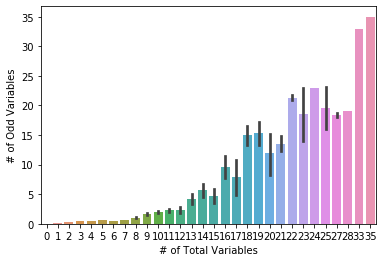

In [155]:
sns.barplot(x="gender", y="numOddVar", data=submissions).set(xlabel='# of Total Variables', ylabel='# of Odd Variables')

In [153]:
submissions["numOddVar"].sum()/submissions["numTotalVar"].sum()

0.13130614060498225

In [164]:
submissions["numDescriptiveVar"].sum()/submissions["numTotalVar"].sum()

0.9039632797567175

In [258]:
people["has_hs_experience"] = False
people["has_uni_experience"] = False
for i in range(0, len(people)):
    priorCSExperience = people.iloc[i].priorCSExperience
    
    people.at[i, "has_hs_experience"] = priorCSExperience == "HS Only" or priorCSExperience == "HS and Uni"
    people.at[i, "has_uni_experience"] = priorCSExperience == "Uni Only" or priorCSExperience == "HS and Uni"
    
people.head()

,email,gender,major,college,priorCSExperience,updated_major,numTotalVar,numOddVar,numDescriptiveVar,percentDescriptiveVar,percentOddVar,avgVarLength,has_hs_experience,has_uni_experience
0,aapccr2@illinois.edu,M,Pre-Engineering,Division of General Studies,HS Only,Other,1334,118,1323,0.991754,0.088456,6.47226,True,False
1,anar9@illinois.edu,M,Engineering Physics,Grainger Engineering,Uni Only,Other,272,3,249,0.915441,0.011029,4.97426,False,True
2,bgpo5@illinois.edu,F,Math & Computer Science,Liberal Arts & Sciences,None,CS+X,2074,266,2010,0.969142,0.128255,7.15767,False,False
3,bkkhyb8@illinois.edu,M,Statistics & Computer Science,Liberal Arts & Sciences,HS Only,CS+X,416,65,398,0.956731,0.156250,5.50962,True,False
4,cqrejfm4@illinois.edu,F,Econometrics & Quant Econ,Liberal Arts & Sciences,Uni Only,Other,68,2,58,0.852941,0.029412,6.89706,False,True


## Major

## Gender

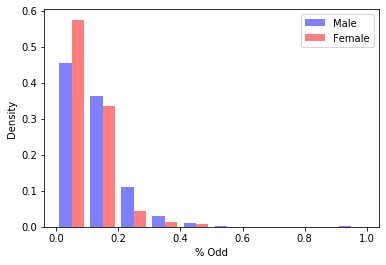

In [283]:
m = people[people["gender"] == "M"]["percentOddVar"]
f = people[people["gender"] == "F"]["percentOddVar"]
m_w = np.empty(m.shape)
m_w.fill(1/m.shape[0])
f_w = np.empty(f.shape)
f_w.fill(1/f.shape[0])

plt.hist([m, f], weights=[m_w, f_w], color=['b','r'], label=['Male', 'Female'], alpha = 0.5)
plt.title('')
plt.xlabel('% Odd')
plt.ylabel('Density')

plt.legend()
plt.show()

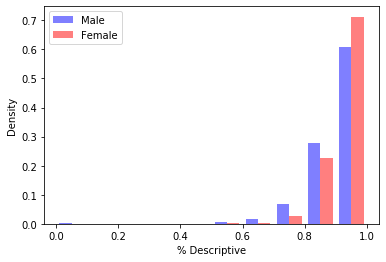

In [284]:
m = people[people["gender"] == "M"]["percentDescriptiveVar"]
f = people[people["gender"] == "F"]["percentDescriptiveVar"]
m_w = np.empty(m.shape)
m_w.fill(1/m.shape[0])
f_w = np.empty(f.shape)
f_w.fill(1/f.shape[0])

plt.hist([m, f], weights=[m_w, f_w], color=['b','r'], label=['Male', 'Female'], alpha = 0.5)
plt.title('')
plt.xlabel('% Descriptive')
plt.ylabel('Density')

plt.legend()
plt.show()

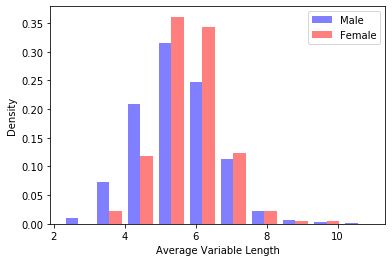

In [285]:
m = people[people["gender"] == "M"]["avgVarLength"].dropna()
f = people[people["gender"] == "F"]["avgVarLength"].dropna()
m_w = np.empty(m.shape)
m_w.fill(1/m.shape[0])
f_w = np.empty(f.shape)
f_w.fill(1/f.shape[0])

plt.hist([m, f], weights=[m_w, f_w], color=['b','r'], label=['Male', 'Female'], alpha = 0.5)
plt.title('')
plt.xlabel('Average Variable Length')
plt.ylabel('Density')

plt.legend()
plt.show()

[Text(0, 0.5, '% Odd'), Text(0.5, 0, 'Gender')]

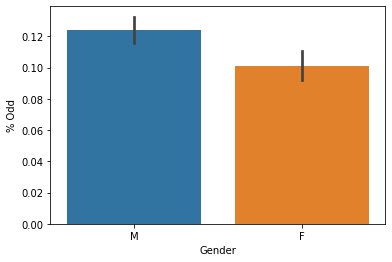

In [235]:
sns.barplot(x="gender", y="percentOddVar", data=people[people["gender"].isin(["M", "F"])]).set(xlabel='Gender', ylabel='% Odd')

[Text(0, 0.5, '% Descriptive'), Text(0.5, 0, 'Gender')]

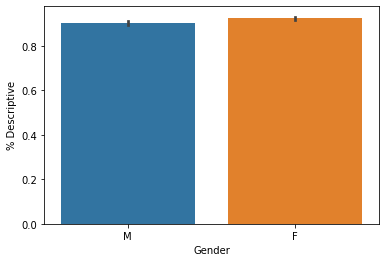

In [282]:
sns.barplot(x="gender", y="percentDescriptiveVar", data=people[people["gender"].isin(["M", "F"])]).set(xlabel='Gender', ylabel='% Descriptive')

[Text(0, 0.5, 'Average Variable Length'), Text(0.5, 0, 'Gender')]

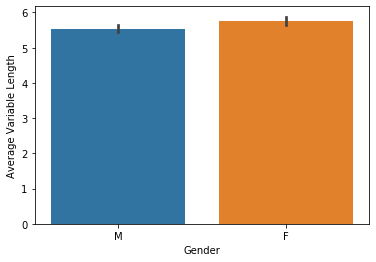

In [276]:
sns.barplot(x="gender", y="avgVarLength", data=people[people["gender"].isin(["M", "F"])]).set(xlabel='Gender', ylabel='Average Variable Length')


In [ ]:
m = submissions[submissions["mode"] == "Public"]["percentOddVar"]
f = submissions[submissions["mode"] == "Exam"]["percentOddVar"]
m_w = np.empty(m.shape)
m_w.fill(1/m.shape[0])
f_w = np.empty(f.shape)
f_w.fill(1/f.shape[0])

plt.hist([m, f], weights=[m_w, f_w], color=['r','b'], label=['Public', 'Exam'], alpha = 0.5)
plt.title('')
plt.xlabel('% Odd')
plt.ylabel('Density')

plt.legend()
plt.show()

## Mode

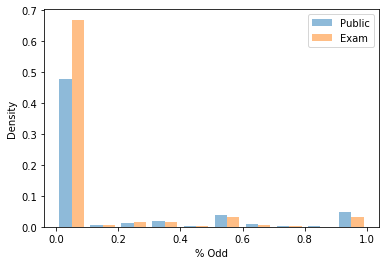

In [290]:
m = submissions[submissions["mode"] == "Public"]["percentOddVar"]
f = submissions[submissions["mode"] == "Exam"]["percentOddVar"]
m_w = np.empty(m.shape)
m_w.fill(1/m.shape[0])
f_w = np.empty(f.shape)
f_w.fill(1/f.shape[0])

plt.hist([m, f], weights=[m_w, f_w], label=['Public', 'Exam'], alpha = 0.5)
plt.title('')
plt.xlabel('% Odd')
plt.ylabel('Density')

plt.legend()
plt.show()

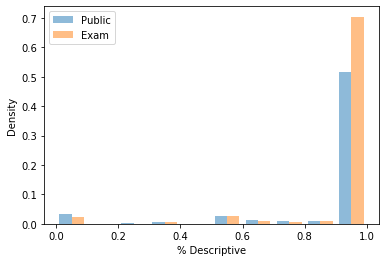

In [291]:
m = submissions[submissions["mode"] == "Public"]["percentDescriptiveVar"]
f = submissions[submissions["mode"] == "Exam"]["percentDescriptiveVar"]
m_w = np.empty(m.shape)
m_w.fill(1/m.shape[0])
f_w = np.empty(f.shape)
f_w.fill(1/f.shape[0])

plt.hist([m, f], weights=[m_w, f_w], label=['Public', 'Exam'], alpha = 0.5)
plt.title('')
plt.xlabel('% Descriptive')
plt.ylabel('Density')

plt.legend()
plt.show()

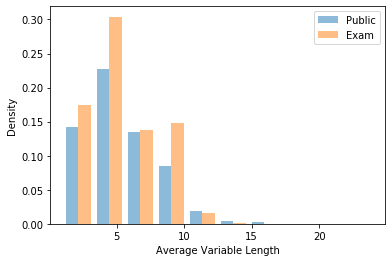

In [293]:
m = submissions[submissions["mode"] == "Public"]["avgVarLength"]
f = submissions[submissions["mode"] == "Exam"]["avgVarLength"]
m_w = np.empty(m.shape)
m_w.fill(1/m.shape[0])
f_w = np.empty(f.shape)
f_w.fill(1/f.shape[0])

plt.hist([m, f], weights=[m_w, f_w], label=['Public', 'Exam'], alpha = 0.5)
plt.title('')
plt.xlabel('Average Variable Length')
plt.ylabel('Density')

plt.legend()
plt.show()

## Significance Tests

In [261]:
model = smf.ols('percentOddVar ~ updated_major + has_hs_experience + has_uni_experience + gender', data=people).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          percentOddVar   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.510
Date:                Tue, 20 Oct 2020   Prob (F-statistic):            0.00103
Time:                        02:51:10   Log-Likelihood:                 764.77
No. Observations:                 740   AIC:                            -1514.
Df Residuals:                     732   BIC:                            -1477.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.1076      0.011     10.072      0.000       0.087       0.129
updated_major[T.CS-Eng]       -0.0115      0.011     -1.013      0.311      -0.034       0.011
updated_major[T.Other]         0.0003      0.009      0.036      0.971      -0.016       0.017
has_hs_experience[T.True]     -0.0094      0.007     -1.311      0.190      -0.023       0.005
has_uni_experience[T.True]     0.0194      0.010      1.847      0.065      -0.001       0.040
gender[T.M]                    0.0213      0.007      3.037      0.002       0.008       0.035
gender[T.None]                -0.0603      0.050     -1.198      0.231      -0.159       0.039
gender[T.Other]               -0.0624      0.062     -1.013      0.311      -0.183       0.059
==============================================================================
Omnibus:                      476.279   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9004.340
Skew:                           2.567   Prob(JB):                         0.00
Kurtosis:                      19.300   Cond. No.                         30.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [262]:
model = smf.ols('percentDescriptiveVar ~ updated_major + has_hs_experience + has_uni_experience + gender', data=people).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     percentDescriptiveVar   R-squared:                       0.020
Model:                               OLS   Adj. R-squared:                  0.011
Method:                    Least Squares   F-statistic:                     2.139
Date:                   Tue, 20 Oct 2020   Prob (F-statistic):             0.0377
Time:                           02:51:30   Log-Likelihood:                 768.36
No. Observations:                    740   AIC:                            -1521.
Df Residuals:                        732   BIC:                            -1484.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.9316      0.011     87.618      0.000       0.911       0.952
updated_major[T.CS-Eng]        0.0054      0.011      0.476      0.634      -0.017       0.027
updated_major[T.Other]        -0.0045      0.009     -0.535      0.593      -0.021       0.012
has_hs_experience[T.True]     -0.0083      0.007     -1.168      0.243      -0.022       0.006
has_uni_experience[T.True]    -0.0081      0.010     -0.772      0.440      -0.029       0.012
gender[T.M]                   -0.0195      0.007     -2.796      0.005      -0.033      -0.006
gender[T.None]                 0.0653      0.050      1.303      0.193      -0.033       0.164
gender[T.Other]                0.0342      0.061      0.559      0.577      -0.086       0.155
==============================================================================
Omnibus:                      685.405   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35986.147
Skew:                          -3.985   Prob(JB):                         0.00
Kurtosis:                      36.221   Cond. No.                         30.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [259]:
model = smf.ols('avgVarLength ~ updated_major + has_hs_experience + has_uni_experience + gender', data=people.astype({"avgVarLength": "float"})).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           avgVarLength   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     4.605
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           4.70e-05
Time:                        02:50:45   Log-Likelihood:                -1089.6
No. Observations:                 740   AIC:                             2195.
Df Residuals:                     732   BIC:                             2232.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      5.5947      0.131     42.732      0.000       5.338       5.852
updated_major[T.CS-Eng]        0.1952      0.139      1.409      0.159      -0.077       0.467
updated_major[T.Other]         0.1310      0.105      1.251      0.211      -0.075       0.337
has_hs_experience[T.True]      0.0951      0.088      1.084      0.279      -0.077       0.267
has_uni_experience[T.True]    -0.1455      0.128     -1.133      0.258      -0.398       0.107
gender[T.M]                   -0.2157      0.086     -2.511      0.012      -0.384      -0.047
gender[T.None]                 2.5113      0.617      4.071      0.000       1.300       3.722
gender[T.Other]                0.3764      0.755      0.499      0.618      -1.105       1.858
==============================================================================
Omnibus:                       59.472   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.033
Skew:                           0.521   Prob(JB):                     4.70e-25
Kurtosis:                       4.597   Cond. No.                         30.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [266]:
model = smf.ols('percentOddVar ~ mode', data=submissions).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          percentOddVar   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2505.
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        03:00:29   Log-Likelihood:                -59906.
No. Observations:              364459   AIC:                         1.198e+05
Df Residuals:                  364457   BIC:                         1.198e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0828      0.001     81.424      0.000       0.081       0.085
mode[T.Public]     0.0575      0.001     50.051      0.000       0.055       0.060
==============================================================================
Omnibus:                   147727.601   Durbin-Watson:                   1.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           474386.721
Skew:                           2.178   Prob(JB):                         0.00
Kurtosis:                       6.502   Cond. No.                         4.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [267]:
model = smf.ols('percentDescriptiveVar ~ mode', data=submissions).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     percentDescriptiveVar   R-squared:                       0.005
Model:                               OLS   Adj. R-squared:                  0.005
Method:                    Least Squares   F-statistic:                     1660.
Date:                   Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                           03:00:30   Log-Likelihood:                 1131.0
No. Observations:                 364459   AIC:                            -2258.
Df Residuals:                     364457   BIC:                            -2236.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9431      0.001   1096.262      0.000       0.941       0.945
mode[T.Public]    -0.0396      0.001    -40.748      0.000      -0.041      -0.038
==============================================================================
Omnibus:                   209704.546   Durbin-Watson:                   1.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1316127.542
Skew:                          -2.875   Prob(JB):                         0.00
Kurtosis:                      10.322   Cond. No.                         4.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [265]:
model = smf.ols('avgVarLength ~ mode', data=submissions).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           avgVarLength   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8504
Date:                Tue, 20 Oct 2020   Prob (F-statistic):              0.356
Time:                        02:59:45   Log-Likelihood:            -8.6918e+05
No. Observations:              364459   AIC:                         1.738e+06
Df Residuals:                  364457   BIC:                         1.738e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.3035      0.009    566.035      0.000       5.285       5.322
mode[T.Public]    -0.0098      0.011     -0.922      0.356      -0.030       0.011
==============================================================================
Omnibus:                    21145.644   Durbin-Watson:                   1.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25683.566
Skew:                           0.593   Prob(JB):                         0.00
Kurtosis:                       3.532   Cond. No.                         4.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [294]:
model = smf.ols('percentOddVar ~ percentDescriptiveVar', data=submissions).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          percentOddVar   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                 5.533e+04
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        06:31:56   Log-Likelihood:                -35397.
No. Observations:              364459   AIC:                         7.080e+04
Df Residuals:                  364457   BIC:                         7.082e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5199      0.002    301.573      0.000       0.516       0.523
percentDescriptiveVar    -0.4297      0.002   -235.227      0.000      -0.433      -0.426
==============================================================================
Omnibus:                   142132.101   Durbin-Watson:                   1.313
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           515310.025
Skew:                           1.997   Prob(JB):                         0.00
Kurtosis:                       7.241   Cond. No.                         7.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""